In [1]:
%pip install -U gymnasium
%pip install -U gymnasium[atari,accept-rom-license]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gymnasium as gym
import torch.nn.functional as F
import argparse

In [3]:
env = gym.make('ALE/Pong-v5')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from gym.wrappers import AtariPreprocessing
import numpy as np

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(obs, env):
    """Performs necessary observation preprocessing."""
    if env in ['CartPole-v1']:
        return torch.tensor(obs, device=device).float()
    elif env in ['ALE/Pong-v5']:
        return torch.tensor(obs, device=device).float()
    else:
        raise ValueError('Please add necessary observation preprocessing instructions to preprocess() in utils.py.')


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (obs, action, next_obs, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample))


class DQNAgent(nn.Module):
    def __init__(self, env_config):
        super(DQNAgent, self).__init__()

        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]
        self.obs_stack = env_config["Observation_stack_size"]

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, self.n_actions)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.step = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epsilons = np.linspace(self.eps_start, self.eps_end,self.anneal_length)
    def forward(self, x):
        """Runs the forward pass of the NN depending on architecture."""

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    def act(self, state, exploit = False):

        epsilon = self.epsilons[min(self.step,self.anneal_length - 1)]
        self.step += 1
        if exploit or np.random.rand() > epsilon:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32, device=self.device)
                q_values = self.forward(state)
                action = torch.argmax(q_values).item()

        else:
            action = np.random.choice(self.n_actions)
        return action

    def optimize(self, memory, batch_size, step, dqnagent, target_dqnagent, optimizer, gamma):
        if len(memory) < batch_size:
            return

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        states, actions, next_states, rewards = memory.sample(dqnagent.batch_size)
        states_set = torch.cat(states, dim=0)
        actions_set = torch.LongTensor(actions).unsqueeze(1).to(device)
        next_states = torch.stack(next_states).squeeze(1).squeeze(1)
        next_states_set = torch.tensor(next_states, dtype=torch.float32, device=device)
        rewards_set = torch.tensor(rewards, dtype=torch.float32, device=device)
        q_values = dqnagent(states_set).gather(1, actions_set)

        with torch.no_grad():
          next_q_values = target_dqnagent(next_states_set).max(1).values
        target_q_values = (next_q_values * gamma) + rewards_set

        loss = F.mse_loss(q_values.squeeze(), target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % env_config['target_update_frequency'] == 0:
            target_dqnagent_state_dict = target_dqnagent.state_dict()
            dqnagent_state_dict = dqnagent.state_dict()
            for i in dqnagent_state_dict:
              target_dqnagent_state_dict[i] = dqnagent_state_dict[i]*0.005 + target_dqnagent_state_dict[i]*(1-0.005)
            target_dqnagent.load_state_dict(target_dqnagent_state_dict)


device cpu


In [7]:

Pong = {
    'Observation_stack_size': 4,
    'memory_size': 10000,
    'n_episodes': 1000,
    'batch_size': 32,
    'target_update_frequency': 1000,
    'train_frequency': 4,
    'gamma': 0.99,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'anneal_length': (10**5)*8,
    'n_actions': 6
}
ENV_CONFIGS = {
    'ALE/Pong-v5': Pong
}


n_episodes = Pong['n_episodes']
returns = []
trailing_avg_returns = []
episodes = list(range(1, n_episodes + 1))
if __name__ == '__main__':
  env = gym.make('ALE/Pong-v5')
  env = gym.wrappers.AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30, scale_obs=True)

  env_config = ENV_CONFIGS['ALE/Pong-v5']
  memory = ReplayMemory(env_config['memory_size'])

  dqnagent = DQNAgent(env_config=env_config).to(device)
  target_dqnagent = DQNAgent(env_config=env_config).to(device)
  target_dqnagent.load_state_dict(dqnagent.state_dict())

  optimizer = torch.optim.Adam(dqnagent.parameters(), lr=env_config['lr'])

  args = argparse.Namespace(
      env='ALE/Pong-v5',
      evaluate_freq=4,
      evaluation_episodes=100
  )

  for episode in range(env_config['n_episodes']):
      state, info = env.reset()
      state = preprocess(state, env=args.env).unsqueeze(0)
      total_reward = 0
      step = 0
      terminated = False
      truncated = False

      obs_stack = torch.cat(env_config['Observation_stack_size'] * [state]).unsqueeze(0)
      while not terminated and not truncated:
          action = dqnagent.act(obs_stack)

          next_state, reward, terminated, truncated, info = env.step(action)
          total_reward += reward
          if not terminated and not truncated:
            next_state = preprocess(next_state, env=args.env).unsqueeze(0).clone().detach().to(device)
            obs_stack = obs_stack.to(device)
            next_obs_stack = torch.cat((obs_stack[:, 1:, ...], next_state.unsqueeze(1)), dim=1).to(device)

            memory.push(obs_stack, action, next_obs_stack, reward)
            obs_stack = next_obs_stack

          if step % env_config["train_frequency"] == 0:
            dqnagent.optimize(memory, env_config['batch_size'], step, dqnagent.to(device), target_dqnagent.to(device), optimizer, env_config['gamma'])

      step += 1

      returns.append(total_reward)

      if len(returns) >= 20:
        average = sum(returns[-20:]) / 20
        trailing_avg_returns.append(average)
      else:
        average = sum(returns) / len(returns)
        trailing_avg_returns.append(average)

      print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

env.close()

<ipython-input-6-94fcfc029a08>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states_set = torch.tensor(next_states, dtype=torch.float32, device=device)
<ipython-input-6-94fcfc029a08>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device)


Episode: 1, Total Reward: -20.0
Episode: 2, Total Reward: -21.0
Episode: 3, Total Reward: -21.0
Episode: 4, Total Reward: -21.0
Episode: 5, Total Reward: -21.0
Episode: 6, Total Reward: -20.0
Episode: 7, Total Reward: -20.0
Episode: 8, Total Reward: -20.0
Episode: 9, Total Reward: -19.0
Episode: 10, Total Reward: -21.0
Episode: 11, Total Reward: -21.0
Episode: 12, Total Reward: -21.0
Episode: 13, Total Reward: -20.0
Episode: 14, Total Reward: -20.0
Episode: 15, Total Reward: -18.0
Episode: 16, Total Reward: -20.0
Episode: 17, Total Reward: -21.0
Episode: 18, Total Reward: -20.0
Episode: 19, Total Reward: -21.0
Episode: 20, Total Reward: -20.0
Episode: 21, Total Reward: -21.0
Episode: 22, Total Reward: -18.0
Episode: 23, Total Reward: -21.0
Episode: 24, Total Reward: -21.0
Episode: 25, Total Reward: -21.0
Episode: 26, Total Reward: -21.0


KeyboardInterrupt: 

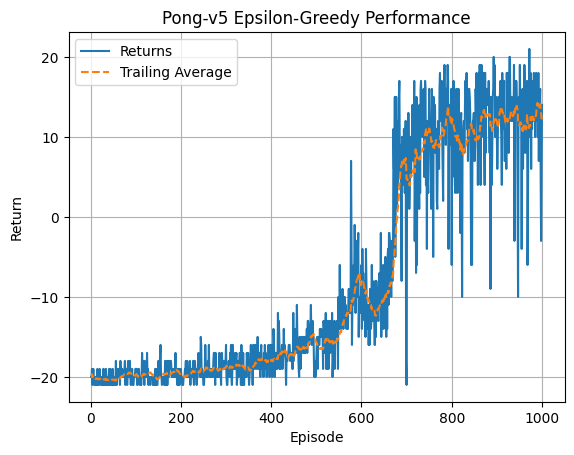

In [13]:
# Plotting
import matplotlib.pyplot as plt

plt.plot(episodes, returns, label='Returns')
plt.plot(episodes, trailing_avg_returns, label='Trailing Average', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Pong-v5 Epsilon-Greedy Performance')
plt.legend()
plt.grid(True)
plt.show()